# 0.0 Imports

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from IPython.display import Image
import datetime

from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler

from scipy.stats import chi2_contingency

import inflection

## 0.1 Helper Functions

In [48]:
def search_outliers(df, series):
    first_quantile = np.quantile(df[series], 0.25)
    third_quantile = np.quantile(df[series], 0.75)
    distance = (third_quantile - first_quantile) * 1.5
    inf_limit = first_quantile - distance
    sup_limit = third_quantile + distance
    index_outliers = df.loc[(df[series]<inf_limit)|(df[series]>sup_limit)].index
    return index_outliers, inf_limit, sup_limit

def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    chi2 = chi2_contingency(cm)[0]
    chi2corr = max(0, chi2-(k-1)*(r-1)/(n-1))
    kcorr = k-(k-1)**2/(n-1)
    rcorr = r-(r-1)**2/(n-1)
    return round(np.sqrt((chi2corr/n)/( min(kcorr-1, rcorr-1))), 2)

## 0.2 Loading Data

In [49]:
store = pd.read_csv('D:\\My Drive\\Pessoal\\Projetos\\rossmann_sales_predict\\data\\raw\\store.csv', low_memory=False)
train = pd.read_csv('D:\\My Drive\\Pessoal\\Projetos\\rossmann_sales_predict\\data\\raw\\train.csv', low_memory=False)

df = pd.merge(train, store, how='left', on='Store')
df.sample(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
299819,953,6,2014-10-25,2086,227,1,0,0,0,a,a,19830.0,4.0,2006.0,1,22.0,2011.0,"Mar,Jun,Sept,Dec"
973648,1039,6,2013-02-09,7775,1081,1,0,0,0,a,c,70.0,6.0,1990.0,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
836060,596,3,2013-06-12,3453,606,1,0,0,0,c,a,290.0,9.0,2006.0,0,NaN,NaN,NaN
45166,567,7,2015-06-21,0,0,0,0,0,0,c,a,1010.0,9.0,2012.0,1,18.0,2011.0,"Feb,May,Aug,Nov"
93352,808,6,2015-05-09,5363,472,1,0,0,0,a,a,18620.0,NaN,NaN,1,31.0,2009.0,"Feb,May,Aug,Nov"


# 1.0 Data Description

In [50]:
df1 = df.copy()

## 1.1 Rename Columns

In [51]:
snake_case = lambda x: inflection.underscore(x)

cols_old = df1.columns.to_list()
cols_new = list(map(snake_case, cols_old))

# rename
df1.columns = cols_new

## 1.2 Data Dimension

In [52]:
print(f'Number of rows: {df1.shape[0]}')
print(f'Number of columns: {df1.shape[1]}')

Number of rows: 1017209
Number of columns: 18


## 1.3 Data Types

In [53]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [54]:
# changing date datatype
df1['date'] = pd.to_datetime(df1['date'])

## 1.4 Check NA

In [55]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [56]:
# competition_distance
df1.loc[df1['competition_distance'].isna(), 'competition_distance'] = 200000

# competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if np.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1) 

# competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if np.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

# promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if np.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if np.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

# promo_interval
df1['promo_interval'].fillna(0, inplace=True)
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sept', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
df1['month_map'] = df1['date'].dt.month.map(month_map)
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)
df1.drop(['promo_interval', 'month_map'], axis=1, inplace=True)

## 1.6 Change Data Types

In [57]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int')

df1['promo2_since_week'] = df1['promo2_since_week'].astype('int')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int')

## 1.7 Descriptive Statistical

### 1.7.1 Classifying Attributes

In [58]:
num_attributes = ['sales', 'customers', 'competition_distance']
cat_attributes = ['open', 'state_holiday', 'school_holiday', 'store_type', 'assortment', 'day_of_week', 'promo', 'promo2', 'is_promo']

### 1.7.2 Numerical Attributes

In [59]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(df1[num_attributes].apply(np.mean)).T
ct2 = pd.DataFrame(df1[num_attributes].apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(df1[num_attributes].apply(np.std)).T
d2 = pd.DataFrame(df1[num_attributes].apply(min)).T
d3 = pd.DataFrame(df1[num_attributes].apply(max)).T
d4 = pd.DataFrame(df1[num_attributes].apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(df1[num_attributes].apply(lambda x: x.skew())).T
d6 = pd.DataFrame(df1[num_attributes].apply(lambda x: x.kurtosis())).T

m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T
m.columns = 'min max range mean median std skew kurtosis'.split()
m

,min,max,range,mean,median,std,skew,kurtosis
sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712


1. sales: a média e a mediana estão próximas, isso indica uma distribuição centralizada na média, a skew é baixa, o que reforça uma distribuição centralizada na média, indicando uma distribuição próxima a uma normal, a skew é positiva, então tem uma cauda direita um pouco mais pesada, kurtosis próxima de 1, inidica um pico não muito alto. A distribuição deve ser parecida com uma NORMAL.
2. customers: a média e a mediana estão prõximas mas com uma diferença de uns 5 porcento, a skew próxima a 1.5 indica um deslocamento da centralização relativamente pequeno, a skew é positiva, então tem uma cauda direita mais pesada, a kurtosis é média, sugerindo um pico relativamente alto. A distribuição pode ser parecida com uma NORMAL.
3. competition_distance: a média e a mediana estão bastante distantes, a skew é altíssima, o que sugerem que a média e a mediana estão bastante deslocadas, é a skew é positiva, portanto uma cauda direita bem mais pesada, a kurtosis é altíssima, o que aponta um pico bastante alto, com uma alta concentração, não centralizada na média, distribuição parece uma POISSON.

### 1.7.3 Categorical Attributes

In [60]:
df1[cat_attributes].apply(lambda x: x.nunique())

open              2
state_holiday     4
school_holiday    2
store_type        4
assortment        3
day_of_week       7
promo             2
promo2            2
is_promo          2
dtype: int64

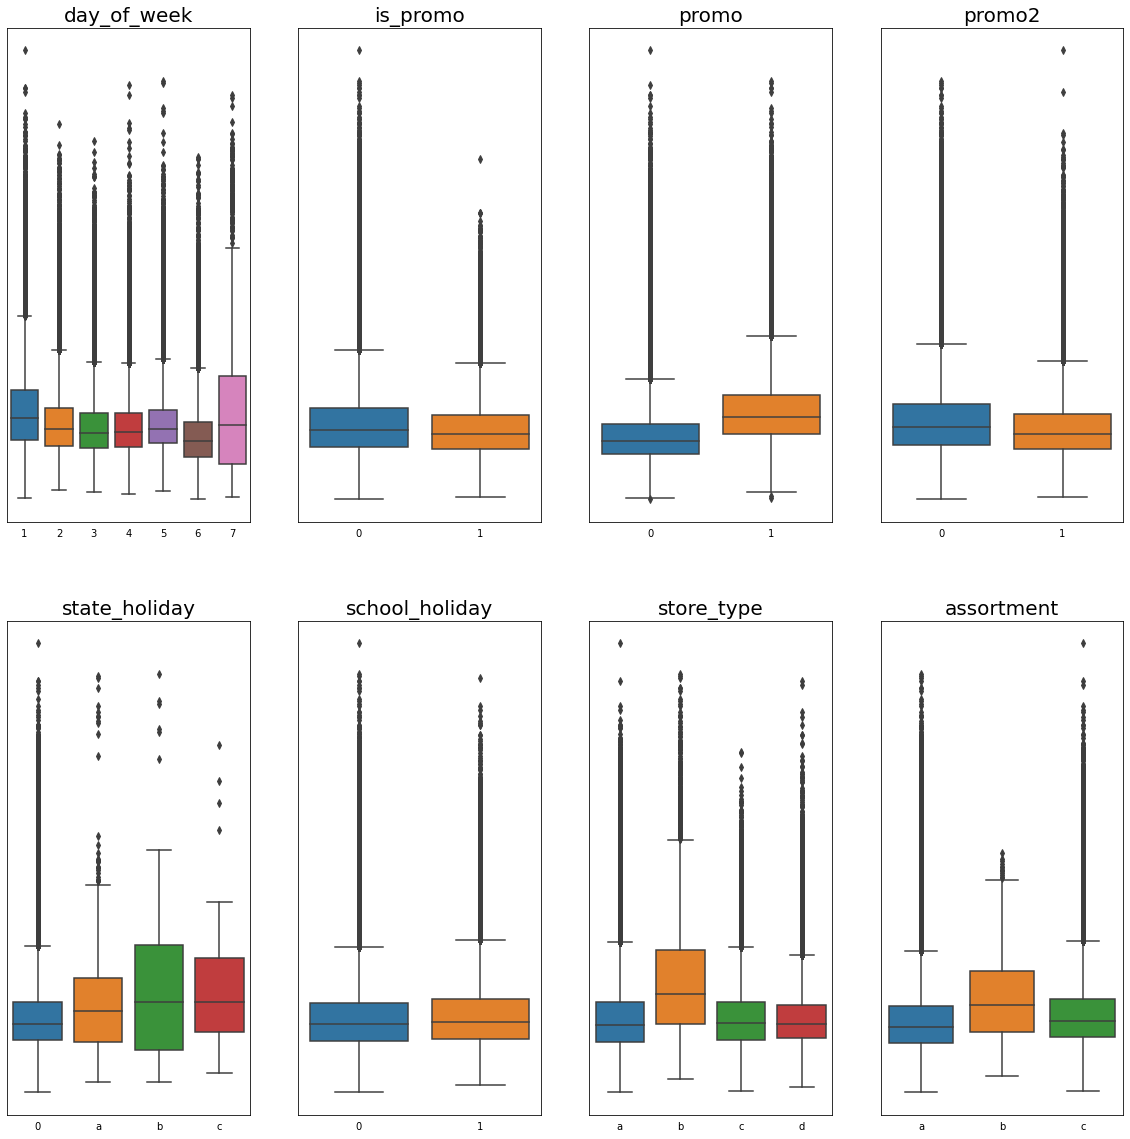

In [61]:
temp = df1[cat_attributes].astype('category')
temp['sales'] = df1['sales']
temp = temp.loc[temp['sales']>0]

plt.figure(figsize=(20, 20))

plt.subplot(2, 4, 1)
ax = sns.boxplot(x='day_of_week', y='sales', data=temp)
ax.tick_params(bottom=False, labelleft=False, left=False)
# ax = sns.despine(left=True)
plt.title('day_of_week', fontsize=20)
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 4, 2)
ax = sns.boxplot(x='is_promo', y='sales', data=temp)
ax.tick_params(bottom=False, labelleft=False, left=False)
# ax = sns.despine(left=True)
plt.title('is_promo', fontsize=20)
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 4, 3)
ax = sns.boxplot(x='promo', y='sales', data=temp)
ax.tick_params(bottom=False, labelleft=False, left=False)
# ax = sns.despine(left=True)
plt.title('promo', fontsize=20)
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 4, 4)
ax = sns.boxplot(x='promo2', y='sales', data=temp)
ax.tick_params(bottom=False, labelleft=False, left=False)
# ax = sns.despine(left=True)
plt.title('promo2', fontsize=20)
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 4, 5)
ax = sns.boxplot(x='state_holiday', y='sales', data=temp)
ax.tick_params(bottom=False, labelleft=False, left=False)
# ax = sns.despine(left=True)
plt.title('state_holiday', fontsize=20)
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 4, 6)
ax = sns.boxplot(x='school_holiday', y='sales', data=temp)
ax.tick_params(bottom=False, labelleft=False, left=False)
# ax = sns.despine(left=True)
plt.title('school_holiday', fontsize=20)
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 4, 7)
ax = sns.boxplot(x='store_type', y='sales', data=temp)
ax.tick_params(bottom=False, labelleft=False, left=False)
# ax = sns.despine(left=True)
plt.title('store_type', fontsize=20)
plt.xlabel('')
plt.ylabel('')

plt.subplot(2, 4, 8)
ax = sns.boxplot(x='assortment', y='sales', data=temp)
ax.tick_params(bottom=False, labelleft=False, left=False)
# ax = sns.despine(left=True)
plt.title('assortment', fontsize=20)
plt.xlabel('')
plt.ylabel('');

1. domingos têm uma distribuição mais espalhada, com maior variância
2. promoções do tipo promo aumentam as vendas
4. feriados geram vendas relativamente maiores e com maior variância
6. store_type do tipo b claramente têm maiores vendas

# 2.0 Feature Engineering

In [62]:
df2 = df1.copy()

## 2.1 Hypothesis Mindmap

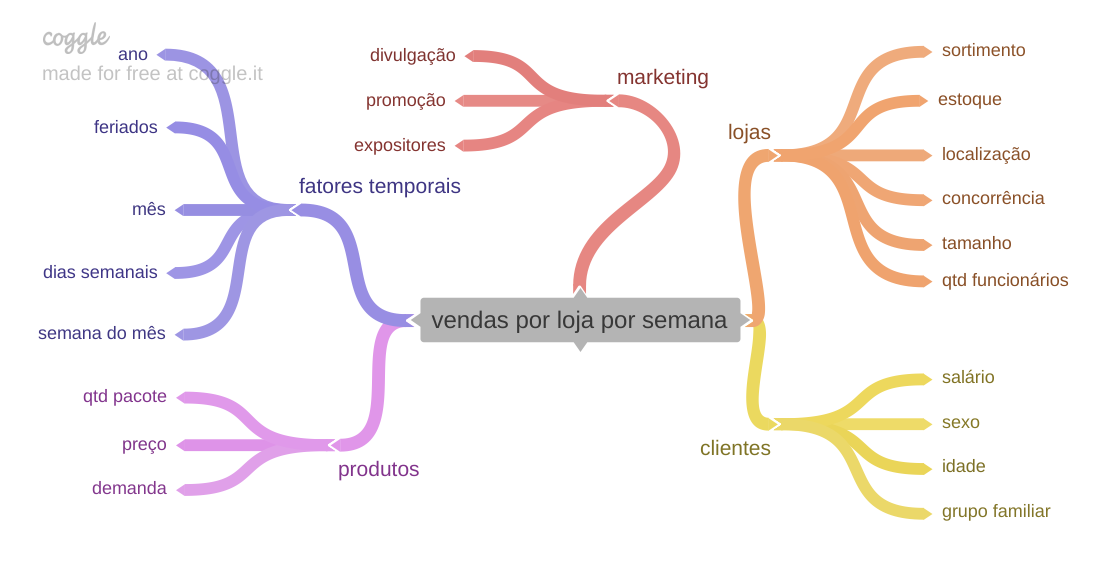

In [63]:
Image('..\\img\\mind_map_hypothesis.png')

## 2.2 Creating Hypothesis

### 2.2.1 Temporal Factors:
1. Com o passar dos anos, as lojas deveriam vender mais.
2. Aos feriados, as lojas deveriam vender mais.
3. Aos ultimos trimestres, as lojas deveriam vender mais.
4. Aos finais de semana, as lojas deveriam vender mais.
5. Às ultimas semanas dos meses, as lojas deveriam vender MENOS.

### 2.2.2 Marketing:
6. Lojas que fazem maior investimento em divulgações, deveriam vender mais.
7. Lojas em Períodos de promoções, deveriam vender mais.
8. Lojas com promoções a mais tempo, deveriam vender mais.
9. Lojas com melhores estruturas de expositores, deveriam vender mais.

### 2.2.3 Clients:
10. Lojas com clientes com maiores salários, deveriam vender mais.
11. Lojas com uma proporção maior de público feminino, deveriam vender mais.
12. Lojas com clientes de faixa etária relativamente maior, deveriam vender mais.
13. Lojas com clientes com grupos familiares maiores, deveriam vender mais.

### 2.2.4 Products:
14. Produtos com pacotes unitários maiores deveriam promover maiores vendas.
15. Produtos com margem de lucro reduzida, deveriam promover maiores vendas.
16. Produtos com maiores demandas, deveriam promover maiores vendas.

### 2.2.5 Stores:
17. Lojas com maior sortimento, deveriam vender mais.
18. Lojas com maiores disponibilidades de estoque, deveriam vender mais.
19. Lojas localizadas em regiões com maiores salários, deveriam vender mais.
20. Lojas com concorrência mais próxima, deveriam vender MENOS.
21. Lojas com concorrência a mais tempo, deveriam vender mais.
22. Lojas de maior porte, deveriam vender mais.
23. Lojas com mais colaboradores, deveriam vender mais.

### 2.2.5 Lista final de hipóteses:

As hipóteses em negrito foram selecionadas e serão estudadas primeiro. O principal critério para selecionar as possíveis hipóteses foi a disponibilidade de features que possibilitem os estudos.

1. Com o passar dos anos, as lojas deveriam vender mais.
2. Aos feriados, as lojas deveriam vender mais.
3. Aos ultimos trimestres, as lojas deveriam vender mais.
4. Aos finais de semana, as lojas deveriam vender mais.
5. Às ultimas semanas dos meses, as lojas deveriam vender MENOS.
6. Lojas em Períodos de promoções, deveriam vender mais.
7. Lojas com promoções a mais tempo, deveriam vender mais.
8. Lojas com maior sortimento, deveriam vender mais.
9. Lojas com concorrência mais próxima, deveriam vender MENOS.
10. Lojas com mais colaboradores, deveriam vender mais.

## 2.3 Creating Features

In [64]:
# week
df2['week'] = df2['date'].dt.isocalendar().week

# year
df2['year'] = df2['date'].dt.year

# year_week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# quarters
df2['year_quarters'] = df2['date'].dt.month.apply(lambda x: 1 if x <= 3 else (2 if x <= 6 else (3 if x <= 9 else 4)))

# weekends
df2['weekends'] = df2['date'].dt.day_name().apply(lambda x: 0 if x not in ['Friday', 'Saturday'] else 1)

# last_week_of_month
df2['last_week_of_month'] = df2['date'].dt.day.apply(lambda x: 0 if x <= 23 else 1)

# competition_since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(day=1, month=x['competition_open_since_month'], year=x['competition_open_since_year']), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype('int')
df2.drop(['competition_since', 'competition_open_since_month', 'competition_open_since_year'], axis=1, inplace=True)

# promo_since
df2['promo2_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo2_since'] = df2['promo2_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo2_time_week'] = ((df2['date'] - df2['promo2_since']) / 7).apply(lambda x: x.days).astype(int)
df2.drop(['promo2_since', 'promo2_since_year', 'promo2_since_week'], axis=1, inplace=True)

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x=='a' else 'extra' if x=='b' else 'extended')

# state_holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x=='a' else 'easter_holiday' if x=='b' else 'christmas' if x=='c' else 'regular_day')

# day_of_week
df2['day_of_week'] = df2['date'].dt.day_name()

# 3.0 Data Filtering

In [65]:
df3 = df2.copy()

## 3.1 Rows filtering

Filtrando lojas fechadas

In [66]:
df3 = df3.loc[(df3['sales']>0)&(df3['open']!=0)]

## 3.2 Columns filtering

In [67]:
cols_drop = ['open', 'customers']
df3 = df3.drop(cols_drop, axis=1)

A coluna customer não poderá seguir para a modelagem, mas permanecerá no dataset para participar da análise exploratória de dados

# 4.0 Exploratory Data Analysis

In [68]:
df4 = df3.copy()

## 4.1 Univariate Analysis

### 4.1.1 Response variable

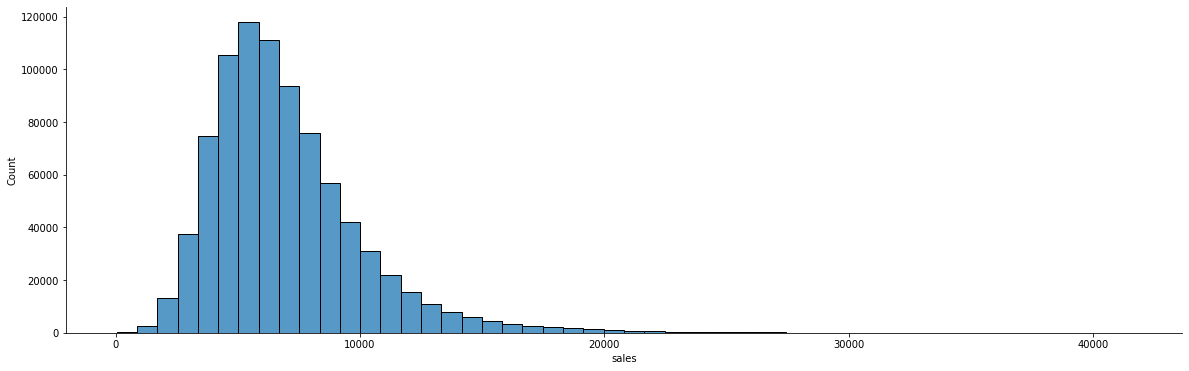

In [69]:
plt.figure(figsize=(20, 6))
sns.histplot(df4['sales'], bins=50)
sns.despine();

Uma distribuição normal, com uma skew positiva, com uma média próxima a 5000

### 4.1.2 Numerical variables

In [70]:
num_attributes.pop(-2)

num_attributes.pop(0) # sales foi dropado porque é a target

num_attributes.append('competition_time_month')
num_attributes.append('promo2_time_week')

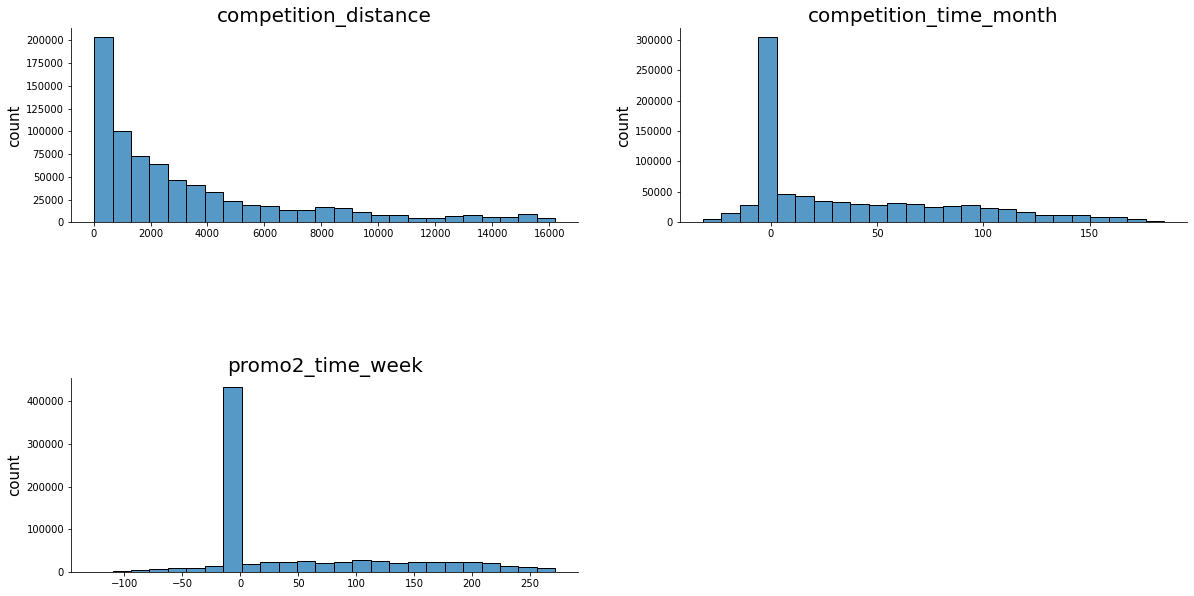

In [71]:
plt.figure(figsize=(20, 10))
plt.subplots_adjust(hspace=0.8)

plt.subplot(2, 2, 1)
outliers_indices, li, ls = search_outliers(df4, 'competition_distance')
temp = df4.drop(outliers_indices)
sns.histplot(temp['competition_distance'], bins=25)
sns.despine()
plt.title('competition_distance', fontsize=20)
plt.xlabel('')
plt.ylabel('count', fontsize=15)

plt.subplot(2, 2, 2)
outliers_indices, li, ls = search_outliers(df4, 'competition_time_month')
temp = df4.drop(outliers_indices)
sns.histplot(temp['competition_time_month'], bins=25)
sns.despine()
plt.title('competition_time_month', fontsize=20)
plt.xlabel('')
plt.ylabel('count', fontsize=15)

plt.subplot(2, 2, 3)
outliers_indices, li, ls = search_outliers(df4, 'promo2_time_week')
temp = df4.drop(outliers_indices)
sns.histplot(temp['promo2_time_week'], bins=25)
sns.despine()
plt.title('promo2_time_week', fontsize=20)
plt.xlabel('')
plt.ylabel('count', fontsize=15);

1. Customers apresenta uma distribuição próxima a uma normal, com uma skew levemente positiva.
2. A maioria das lojas tem concorrência bastante próxima, uma distribuição parecida com uma Poisson, com uma skew positiva.
3. Competition_time_month com valores bem distribuidos e esparsos.
4. promo2_time_week com valores bem distribuídos e esparços.

### 4.1.2 Categorical variables

In [72]:
cat_attributes.pop(0) # dropando open

temp = 'week year year_quarters weekends last_week_of_month'.split()
cat_attributes.extend(temp)

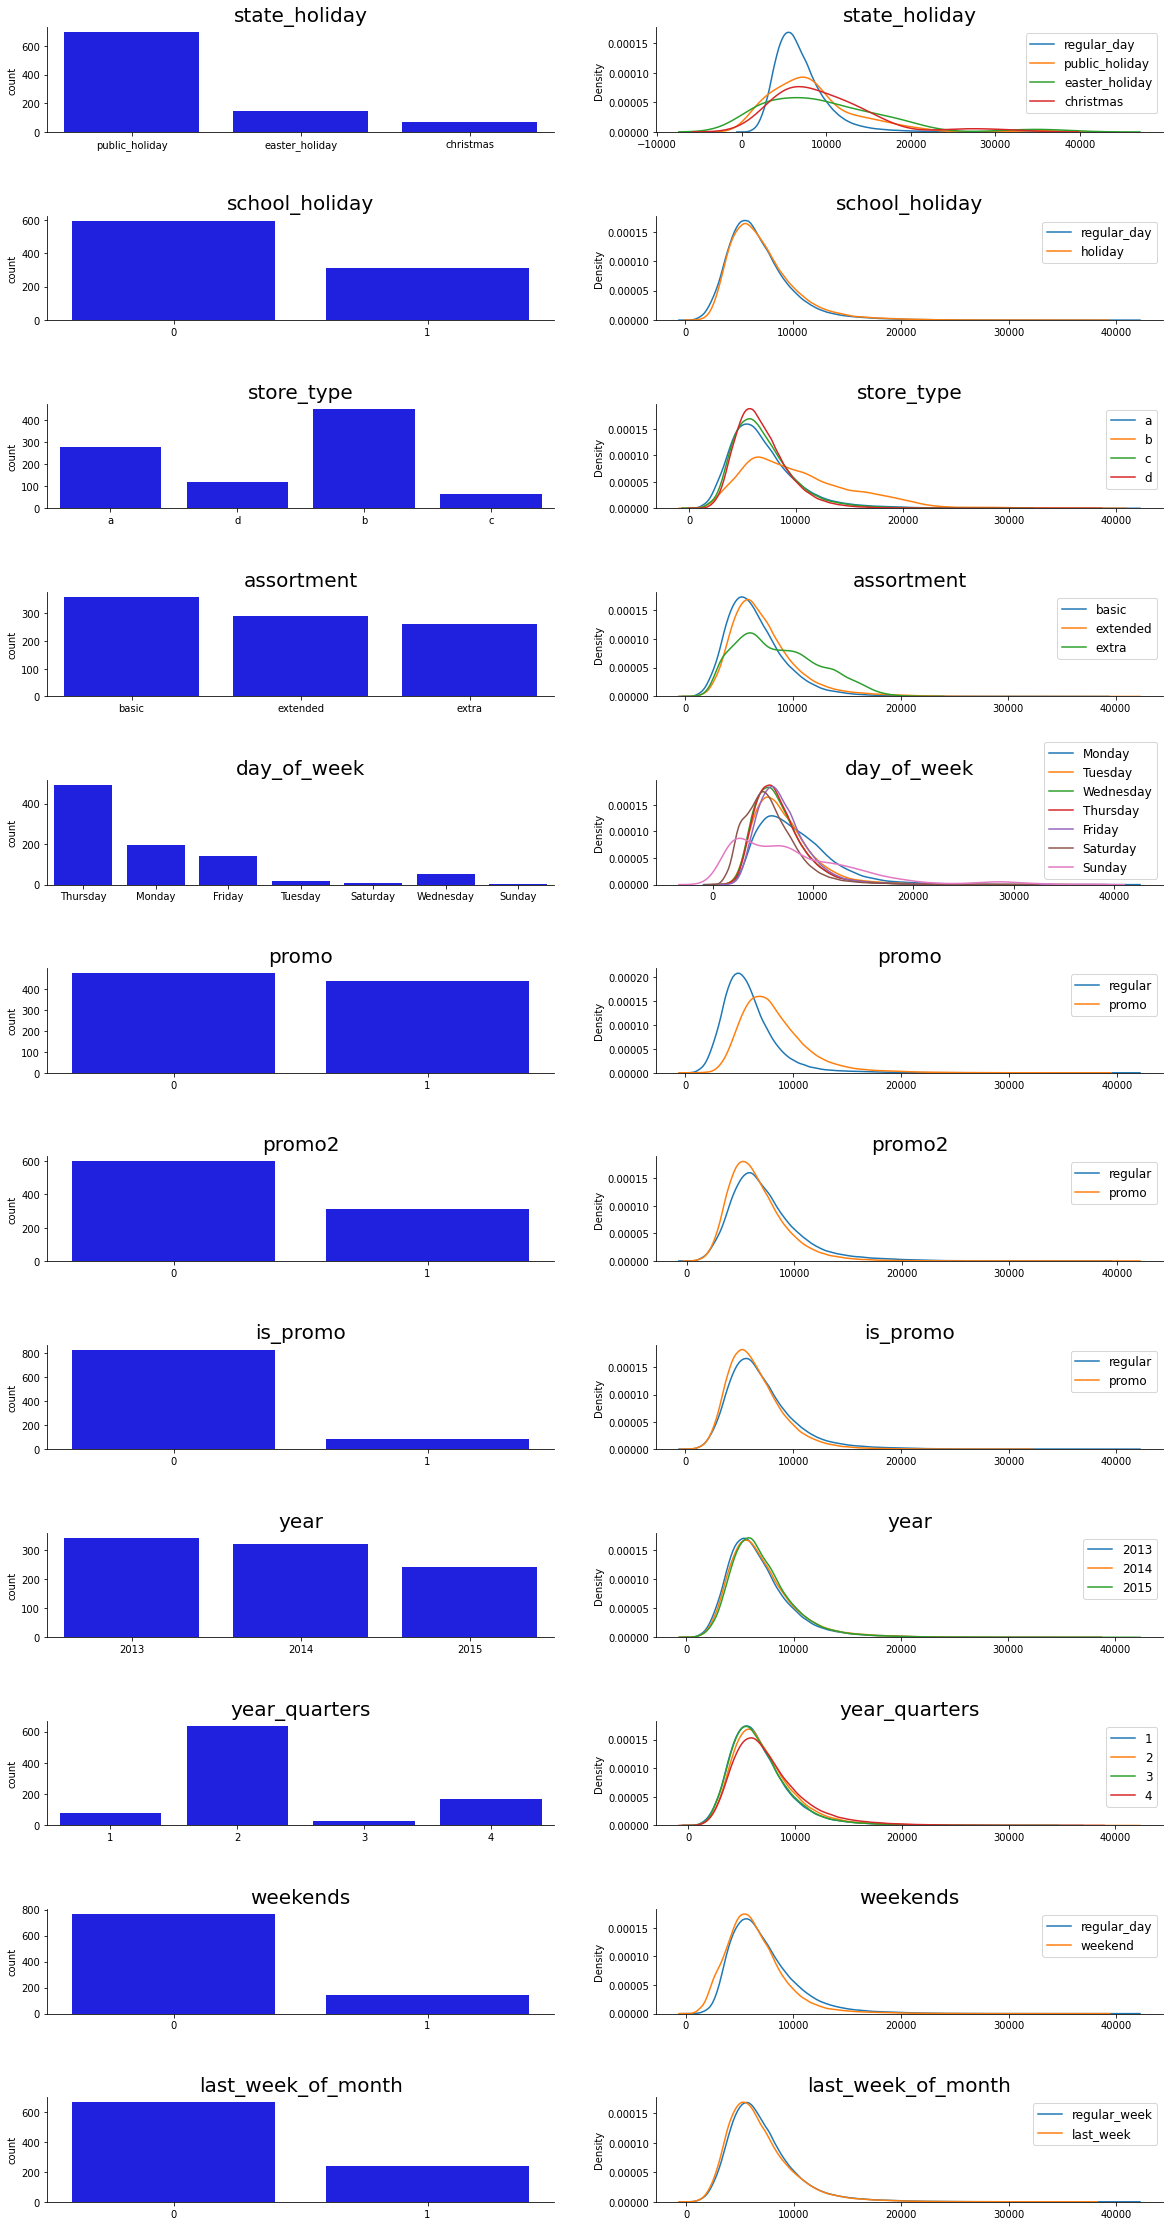

In [73]:
plt.figure(figsize=(20, 40))
plt.subplots_adjust(hspace=0.8)

# state_holiday
plt.subplot(12, 2, 1)
temp = df4[df4['state_holiday']!='regular_day']
sns.countplot(x='state_holiday', data=temp, color='b')
plt.title('state_holiday', fontsize=20)
plt.xlabel('')
sns.despine()

plt.subplot(12, 2, 2)
sns.kdeplot(x='sales', data=df4.loc[df4['state_holiday']=='regular_day'], label='regular_day')
sns.kdeplot(x='sales', data=df4.loc[df4['state_holiday']=='public_holiday'], label='public_holiday')
sns.kdeplot(x='sales', data=df4.loc[df4['state_holiday']=='easter_holiday'], label='easter_holiday')
sns.kdeplot(x='sales', data=df4.loc[df4['state_holiday']=='christmas'], label='christmas')
plt.title('state_holiday', fontsize=20)
plt.xlabel('')
plt.legend(prop={'size': 12})
sns.despine()

# school_holiday
plt.subplot(12, 2, 3)
sns.countplot(x='school_holiday', data=temp, color='b')
plt.title('school_holiday', fontsize=20)
plt.xlabel('')
sns.despine()

plt.subplot(12, 2, 4)
sns.kdeplot(x='sales', data=df4.loc[df4['school_holiday']==0], label='regular_day')
sns.kdeplot(x='sales', data=df4.loc[df4['school_holiday']==1], label='holiday')
plt.title('school_holiday', fontsize=20)
plt.xlabel('')
plt.legend(prop={'size': 12})
sns.despine()

# store_type
plt.subplot(12, 2, 5)
sns.countplot(x='store_type', data=temp, color='b')
plt.title('store_type', fontsize=20)
plt.xlabel('')
sns.despine()

plt.subplot(12, 2, 6)
sns.kdeplot(x='sales', data=df4.loc[df4['store_type']=='a'], label='a')
sns.kdeplot(x='sales', data=df4.loc[df4['store_type']=='b'], label='b')
sns.kdeplot(x='sales', data=df4.loc[df4['store_type']=='c'], label='c')
sns.kdeplot(x='sales', data=df4.loc[df4['store_type']=='d'], label='d')
plt.title('store_type', fontsize=20)
plt.xlabel('')
plt.legend(prop={'size': 12})
sns.despine()

# assortment
plt.subplot(12, 2, 7)
sns.countplot(x='assortment', data=temp, color='b')
plt.title('assortment', fontsize=20)
plt.xlabel('')
sns.despine()

plt.subplot(12, 2, 8)
sns.kdeplot(x='sales', data=df4.loc[df4['assortment']=='basic'], label='basic')
sns.kdeplot(x='sales', data=df4.loc[df4['assortment']=='extended'], label='extended')
sns.kdeplot(x='sales', data=df4.loc[df4['assortment']=='extra'], label='extra')
plt.title('assortment', fontsize=20)
plt.xlabel('')
plt.legend(prop={'size': 12})
sns.despine()

# day_of_week
plt.subplot(12, 2, 9)
sns.countplot(x='day_of_week', data=temp, color='b')
plt.title('day_of_week', fontsize=20)
plt.xlabel('')
sns.despine()

plt.subplot(12, 2, 10)
sns.kdeplot(x='sales', data=df4.loc[df4['day_of_week']=='Monday'], label='Monday')
sns.kdeplot(x='sales', data=df4.loc[df4['day_of_week']=='Tuesday'], label='Tuesday')
sns.kdeplot(x='sales', data=df4.loc[df4['day_of_week']=='Wednesday'], label='Wednesday')
sns.kdeplot(x='sales', data=df4.loc[df4['day_of_week']=='Thursday'], label='Thursday')
sns.kdeplot(x='sales', data=df4.loc[df4['day_of_week']=='Friday'], label='Friday')
sns.kdeplot(x='sales', data=df4.loc[df4['day_of_week']=='Saturday'], label='Saturday')
sns.kdeplot(x='sales', data=df4.loc[df4['day_of_week']=='Sunday'], label='Sunday')
plt.title('day_of_week', fontsize=20)
plt.xlabel('')
plt.legend(prop={'size': 12})
sns.despine()

# promo
plt.subplot(12, 2, 11)
sns.countplot(x='promo', data=temp, color='b')
plt.title('promo', fontsize=20)
plt.xlabel('')
sns.despine()

plt.subplot(12, 2, 12)
sns.kdeplot(x='sales', data=df4.loc[df4['promo']==0], label='regular')
sns.kdeplot(x='sales', data=df4.loc[df4['promo']==1], label='promo')
plt.title('promo', fontsize=20)
plt.xlabel('')
plt.legend(prop={'size': 12})
sns.despine()

# promo2
plt.subplot(12, 2, 13)
sns.countplot(x='promo2', data=temp, color='b')
plt.title('promo2', fontsize=20)
plt.xlabel('')
sns.despine()

plt.subplot(12, 2, 14)
sns.kdeplot(x='sales', data=df4.loc[df4['promo2']==0], label='regular')
sns.kdeplot(x='sales', data=df4.loc[df4['promo2']==1], label='promo')
plt.title('promo2', fontsize=20)
plt.xlabel('')
plt.legend(prop={'size': 12})
sns.despine()

# is_promo
plt.subplot(12, 2, 15)
sns.countplot(x='is_promo', data=temp, color='b')
plt.title('is_promo', fontsize=20)
plt.xlabel('')
sns.despine()

plt.subplot(12, 2, 16)
sns.kdeplot(x='sales', data=df4.loc[df4['is_promo']==0], label='regular')
sns.kdeplot(x='sales', data=df4.loc[df4['is_promo']==1], label='promo')
plt.title('is_promo', fontsize=20)
plt.xlabel('')
plt.legend(prop={'size': 12})
sns.despine()

# year
plt.subplot(12, 2, 17)
sns.countplot(x='year', data=temp, color='b')
plt.title('year', fontsize=20)
plt.xlabel('')
sns.despine()

plt.subplot(12, 2, 18)
sns.kdeplot(x='sales', data=df4.loc[df4['year']==2013], label='2013')
sns.kdeplot(x='sales', data=df4.loc[df4['year']==2014], label='2014')
sns.kdeplot(x='sales', data=df4.loc[df4['year']==2015], label='2015')
plt.title('year', fontsize=20)
plt.xlabel('')
plt.legend(prop={'size': 12})
sns.despine()

# year_quarters
plt.subplot(12, 2, 19)
sns.countplot(x='year_quarters', data=temp, color='b')
plt.title('year_quarters', fontsize=20)
plt.xlabel('')
sns.despine()

plt.subplot(12, 2, 20)
sns.kdeplot(x='sales', data=df4.loc[df4['year_quarters']==1], label='1')
sns.kdeplot(x='sales', data=df4.loc[df4['year_quarters']==2], label='2')
sns.kdeplot(x='sales', data=df4.loc[df4['year_quarters']==3], label='3')
sns.kdeplot(x='sales', data=df4.loc[df4['year_quarters']==4], label='4')
plt.title('year_quarters', fontsize=20)
plt.xlabel('')
plt.legend(prop={'size': 12})
sns.despine()

# weekends
plt.subplot(12, 2, 21)
sns.countplot(x='weekends', data=temp, color='b')
plt.title('weekends', fontsize=20)
plt.xlabel('')
sns.despine()

plt.subplot(12, 2, 22)
sns.kdeplot(x='sales', data=df4.loc[df4['weekends']==0], label='regular_day')
sns.kdeplot(x='sales', data=df4.loc[df4['weekends']==1], label='weekend')
plt.title('weekends', fontsize=20)
plt.xlabel('')
plt.legend(prop={'size': 12})
sns.despine()

# last_week_of_month
plt.subplot(12, 2, 23)
sns.countplot(x='last_week_of_month', data=temp, color='b')
plt.title('last_week_of_month', fontsize=20)
plt.xlabel('')
sns.despine()

plt.subplot(12, 2, 24)
sns.kdeplot(x='sales', data=df4.loc[df4['last_week_of_month']==0], label='regular_week')
sns.kdeplot(x='sales', data=df4.loc[df4['last_week_of_month']==1], label='last_week')
plt.title('last_week_of_month', fontsize=20)
plt.xlabel('')
plt.legend(prop={'size': 12})
sns.despine();
# week

## 4.2 Bivariate Analysis

#### H1 Com o passar dos anos, as lojas deveriam vender mais.

Hipótese refutada, as vendas permanecem estáveis com o passar dos anos

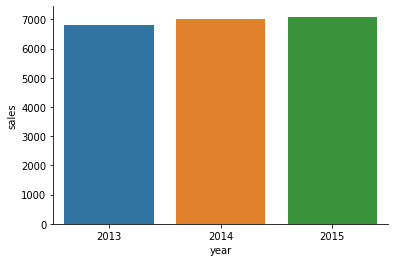

In [74]:
temp = df4.groupby('year').agg({'sales':'mean'}).reset_index()
sns.barplot(x='year', y='sales', data=temp)
sns.despine();

#### H2 Aos feriados, as lojas deveriam vender mais

#### H3 Aos ultimos trimestres, as lojas deveriam vender mais.

#### H4 Aos finais de semana, as lojas deveriam vender mais.

#### H5 Às ultimas semanas dos meses, as lojas deveriam vender MENOS.**.

#### H6 Períodos de promoções, deveriam vender mais.

#### H7 Lojas com promoções a mais tempo, deveriam vender mais.

#### H8 Lojas com maior sortimento, deveriam vender mais.

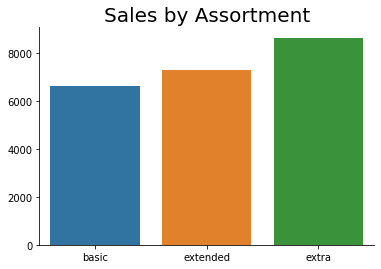

In [75]:
temp = df4.groupby('assortment').agg({'sales':'mean'}).reset_index()
sns.barplot(x='assortment', y='sales', data=temp)
sns.despine()
plt.ylabel('')
plt.xlabel('')
plt.title('Sales by Assortment', fontsize=20);

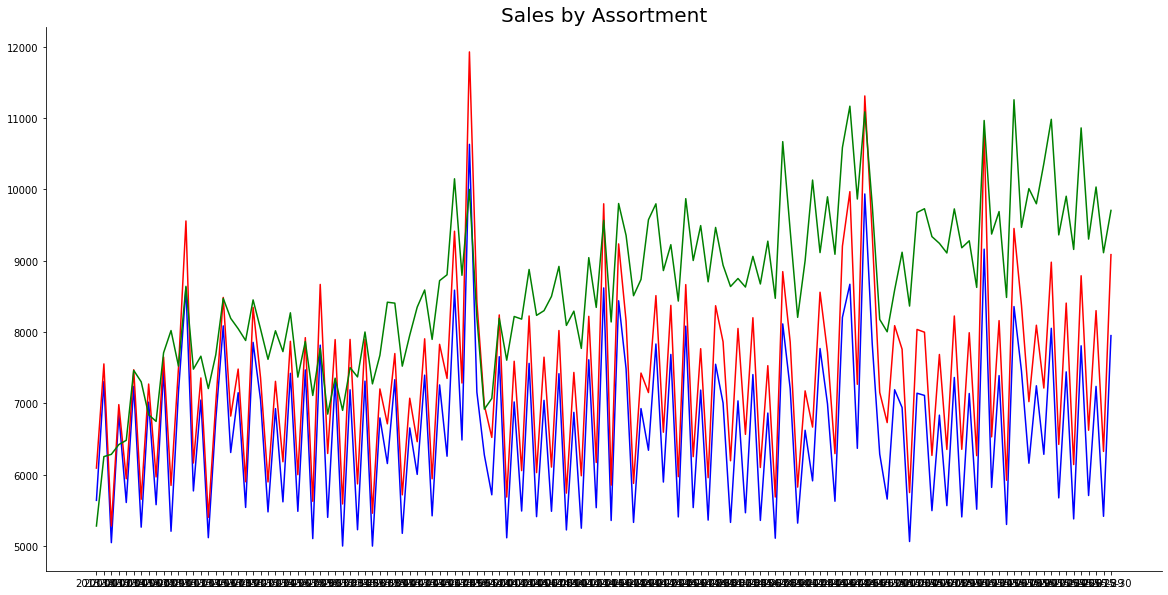

In [76]:
plt.figure(figsize=(20, 10))
temp = df4.groupby(['year_week', 'assortment']).agg({'sales':'mean'}).reset_index()
temp = temp.pivot(index='year_week', columns='assortment', values='sales')
sns.lineplot(x='year_week', y='basic', data=temp, color='b')
sns.lineplot(x='year_week', y='extended', data=temp, color='r')
sns.lineplot(x='year_week', y='extra', data=temp, color='g')
sns.despine()
plt.ylabel('')
plt.xlabel('')
plt.title('Sales by Assortment', fontsize=20);

#### H9 Lojas com concorrência mais próxima, deveriam vender **MENOS**.

#### H10 Lojas com concorrência a mais tempo, deveriam vender mais.

## 4.3 Multivariate Analysis

### 4.3.1 Numerical Attributes

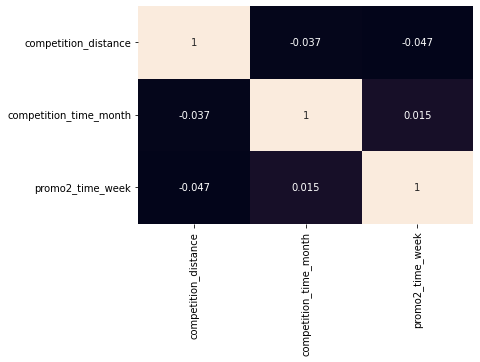

In [77]:
sns.heatmap(df4[num_attributes].corr(), annot=True, cbar=False);

### 4.3.2 Categorical Attributes

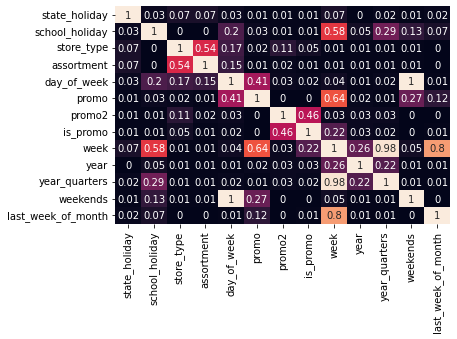

In [78]:
cramer_correlation = []

for i, col_1 in enumerate(cat_attributes):
    for j, col_2 in enumerate(cat_attributes):
        cramer_correlation.append(cramer_v(df4[col_1], df4[col_2]))
        
matrix = pd.DataFrame(np.array(cramer_correlation).reshape(13, 13), index=cat_attributes, columns=cat_attributes)

sns.heatmap(matrix, annot=True, cbar=False);

# 5.0 Data Preparation

In [93]:
df5 = df4.copy()

## 5.1 Normalization

## 5.2 Rescalling

In [94]:
# 'competition_distance'
rs_competition_distance = RobustScaler().fit(df5[['competition_distance']].values)
df5['competition_distance'] = rs_competition_distance.transform(df5[['competition_distance']].values)

# 'competition_time_month'
rs_competition_time_month = RobustScaler().fit(df5[['competition_time_month']].values)
df5['competition_time_month'] = rs_competition_distance.transform(df5[['competition_time_month']].values)

# 'promo2_time_week'
mm_promo2_time_week = MinMaxScaler().fit(df5[['promo2_time_week']].values)
df5['promo2_time_week'] = mm_promo2_time_week.transform(df5[['promo2_time_week']].values)

## 5.3 Transformation

### 5.3.1 Encoding

In [95]:
# 'state_holiday'
map_state_holiday = {'regular_day': 0, 'public_holiday':1, 'easter_holiday':2, 'christmas':3}
df5['state_holiday'] = df5['state_holiday'].map(map_state_holiday)

# 'store_type'
map_store_type = {'a':1, 'b':2, 'c':3, 'd':4}
df5['store_type'] = df5['store_type'].map(map_store_type)

# 'assortment'
map_assortment = {'basic':1, 'extended':2, 'extra':3}
df5['assortment'] = df5['assortment'].map(map_assortment)

# 'year'
map_year = {2013:1, 2014:2, 2015:3}
df5['year'] = df5['year'].map(map_year)

### 5.3.2 Response Variable Transformation

In [96]:
# 'sales'
df5['sales'] = np.log1p(df5['sales'])

### 5.3.3 Nature Transformation

In [97]:
# 'day_of_week'
df5['day_of_week'] = df5['date'].dt.dayofweek
cicle = df5['day_of_week'].max() - df5['day_of_week'].min() + 1
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x*(2*np.pi/cicle)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x*(2*np.pi/cicle)))
df5.drop('day_of_week', axis=1, inplace=True)

# 'week'
cicle = df5['week'].max() - df5['week'].min() + 1
df5['week'] = df5['week'].apply(lambda x: np.sin(x*(2*np.pi/cicle)))
df5['week'] = df5['week'].apply(lambda x: np.cos(x*(2*np.pi/cicle)))
df5.drop('week', axis=1, inplace=True)

# 'year_quarters'
cicle = df5['year_quarters'].max() - df5['year_quarters'].min() + 1
df5['year_quarters'] = df5['year_quarters'].apply(lambda x: np.sin(x*(2*np.pi/cicle)))
df5['year_quarters'] = df5['year_quarters'].apply(lambda x: np.cos(x*(2*np.pi/cicle)))
df5.drop('year_quarters', axis=1, inplace=True)

In [98]:
df5.head()

,store,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,promo2,is_promo,year,year_week,weekends,last_week_of_month,competition_time_month,promo2_time_week,day_of_week_sin,day_of_week_cos
0,1,2015-07-31,8.568646,1,0,1,3,1,-0.170968,0,0,3,2015-30,1,1,-0.362258,0.287016,-0.433884,-0.900969
1,2,2015-07-31,8.710290,1,0,1,1,1,-0.283871,1,1,3,2015-30,1,1,-0.360645,0.922551,-0.433884,-0.900969
2,3,2015-07-31,9.025816,1,0,1,1,1,1.903226,1,1,3,2015-30,1,1,-0.358871,0.801822,-0.433884,-0.900969
3,4,2015-07-31,9.546527,1,0,1,3,2,-0.275806,0,0,3,2015-30,1,1,-0.364355,0.287016,-0.433884,-0.900969
4,5,2015-07-31,8.481151,1,0,1,1,1,4.448387,0,0,3,2015-30,1,1,-0.375161,0.287016,-0.433884,-0.900969
